### Import libraries

In [52]:
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# set notebook style to seaborn
#sns.set_style("white", {"font_scale": 1.5})
sns.set_theme(style="white", font_scale=1.1)

### Import model and simulate the medium

In [53]:
import pandas as pd
from cobra.io import read_sbml_model

# Load the model
iML1515 = read_sbml_model('Models/iML1515.xml')

# Define a function to find carbon-containing reactions
def find_carbon_reactions(model):
    return [(reaction.id, reaction.name) for reaction in model.exchanges 
            if any("C" in metabolite.elements for metabolite in reaction.reactants)]

# Find all carbon-containing reactions
carbon_reactions = find_carbon_reactions(iML1515)

# Simulate and collect data
data = []
with iML1515:
    original_medium = iML1515.medium.copy()
    original_objective = iML1515.objective

    for reaction_id, reaction_name in carbon_reactions:
        iML1515.medium = {**original_medium, 'EX_glc__D_e': 0, reaction_id: 1}

        # Calculate max growth
        iML1515.objective = original_objective
        max_growth = iML1515.slim_optimize(error_value=0.)

        # Calculate max production of L-aspartate
        iML1515.objective = iML1515.reactions.EX_asp__L_e
        max_production = iML1515.slim_optimize(error_value=0.)

        if max_growth != 0:
            data.append([reaction_name, max_growth, max_production])

        iML1515.medium = original_medium  # Reset the medium

# Create DataFrame
df = pd.DataFrame(data, columns=['Carbon', 'Growth', 'Production'])

# Display the DataFrame
df.head()  # Show the first few rows


,Carbon,Growth,Production
0,N-Acetyl-D-glucosamine exchange,0.089370,1.837241
1,Cellobiose exchange,0.154755,3.190690
2,Hypoxanthine exchange,0.005009,0.111209
3,L-Lactate exchange,0.011857,0.256327
4,D-Gluconate exchange,0.055878,1.181497


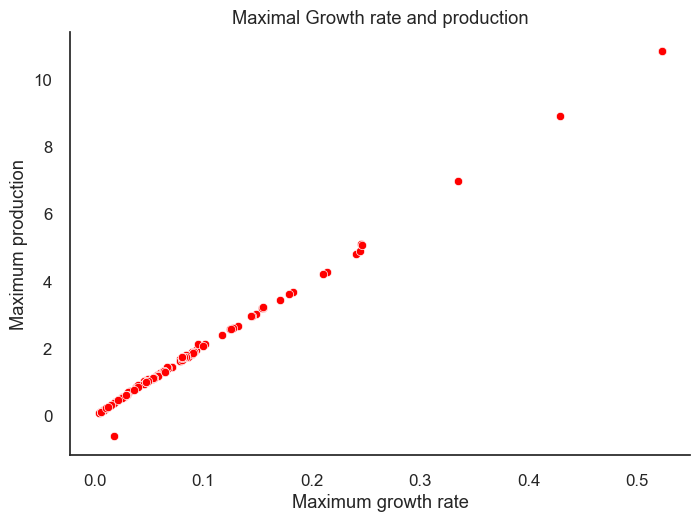

In [54]:
# We create a scatterplot of the production over growth to view the distribution
sns.scatterplot(data=df, x='Growth', y='Production', color='red')


plt.xlabel('Maximum growth rate')
plt.ylabel('Maximum production')
#plt.xlim(0, 0.9)
#plt.ylim(0, 0.5)
plt.title('Maximal Growth rate and production')
sns.despine()
#plt.savefig("figures/carbon_sources")
plt.show()

In [55]:
# We write a new model with glucose as the carbon source
medium=iML1515.medium
medium['EX_glc__D_e'] = 10
iML1515.medium = medium
write_sbml_model(iML1515, "Models/iML1515_modified_glucose.xml") # creates a new file
iML1515_glucose = read_sbml_model('Models/iML1515_modified_glucose.xml') # set model to new file
iML1515_glucose.medium 

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [56]:
#set the optimal value for biomass to 100%
iML1515_glucose.reactions.BIOMASS_Ec_iML1515_core_75p37M.upper_bound=0.87699721425716
#set the lower bound to not be less than 75 % of the optimal value
iML1515_glucose.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound=0.87699721425716*0.75
#print the new objective value
iML1515_glucose_BM_optimized = print(iML1515.optimize().objective_value)

0.8769972144270545


In [57]:
# Claculate the max. theoretical yield for production of l-aspartate on glucose
with iML1515_glucose:
    iML1515_glucose.objective = iML1515_glucose.reactions.EX_asp__L_e
    Asp_production_1 = iML1515_glucose.optimize().objective_value
    max_yield_glucose = Asp_production_1/ (-1*iML1515_glucose.reactions.EX_glc__D_e.flux)
    #set the optimal value for biomass to 100%
print("Max. l-aspartate production [mmol gDW^-1 h^-1]:", Asp_production_1)
print("Theoretical max. yield [mmol-asp / mmol-glucose]:", max_yield_glucose)

Max. l-aspartate production [mmol gDW^-1 h^-1]: 4.548604209060673
Theoretical max. yield [mmol-asp / mmol-glucose]: 0.45486042090606726


In [58]:
#In cmol/cmol
CV_Asp = 4
CV_glc = 6
Asp_glucose_production_cmol = (max_yield_glucose*CV_Asp)/(1*CV_glc)
print('Maximum theoretical yield of L-aspartate=', Asp_glucose_production_cmol, 'cmol-Asp/cmol-glc')

Maximum theoretical yield of L-aspartate= 0.30324028060404484 cmol-Asp/cmol-glc


In [59]:
# Let's check the top 20 carbon sources that result in the highest growth
df.sort_values(by='Growth', ascending=False).head(20)

,Carbon,Growth,Production
120,Maltohexaose exchange,0.523400,10.837241
135,"1,4-alpha-D-glucan exchange",0.523400,10.837241
49,Maltopentaose exchange,0.429358,8.906207
151,Maltotetraose exchange,0.335316,6.975172
169,N-Acetyl-D-glucosamine(anhydrous)N-Acetylmuram...,0.246752,5.070000
85,Maltotriose exchange,0.245036,5.109020
72,Octadecenoate (n-C18:1) exchange,0.244296,4.881905
68,Octadecanoate (n-C18:0) exchange,0.240697,4.818413
40,Hexadecenoate (n-C16:1) exchange,0.213709,4.278730
104,Hexadecanoate (n-C16:0) exchange,0.210111,4.215238


In [60]:
# We have chosen 3 of interest, first we investigate maltohezaose
for reaction in iML1515.reactions.query('Maltohexaose exchange', 'name'):
    print(reaction.id)

EX_malthx_e


In [61]:
# Changing the carbon source to Maltohexaose:
medium=iML1515.medium
medium['EX_glc__D_e'] = 0
medium["EX_malthx_e"]= 10 # we set it to 10 as with glucose in the base medium
iML1515.medium = medium
write_sbml_model(iML1515, "Models/iML1515_modified_malthx.xml") # we create new file
iML1515_maltohexaose = read_sbml_model('Models/iML1515_modified_malthx.xml') # we set model to new file
iML1515_maltohexaose.medium 



{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_malthx_e': 10.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [62]:
# Claculate the maximum theoretical yield for production on Maltohexaose
with iML1515_maltohexaose:
    iML1515_maltohexaose.objective = iML1515_maltohexaose.reactions.EX_asp__L_e
    Asp_production_2 = iML1515_maltohexaose.optimize().objective_value
    max_yield_maltohexaose = Asp_production_2 / (-1*iML1515_maltohexaose.reactions.EX_malthx_e.flux)
    print("Max. l-aspartate production [mmol gDW^-1 h^-1]:", Asp_production_2)
    print("Max. theoretical yield [mmol-asp / mmol-maltohexaose]:", max_yield_maltohexaose) 

Max. l-aspartate production [mmol gDW^-1 h^-1]: 112.63034482758619
Max. theoretical yield [mmol-asp / mmol-maltohexaose]: 11.263034482758618


In [63]:
# Now we convert to Cmol/Cmol
CV_asp = 4 # Cmol/mol conversion factor for l asprtate
CV_malthx = 36 # Cmol/mol conversion factor for malthx

asp_malthx_production_cmol = (max_yield_maltohexaose*CV_asp)/(1*CV_malthx)
print('Maximum theoretical yield cmol/cmol=', asp_malthx_production_cmol, 'cmol-asp/cmol-malthx')

Maximum theoretical yield cmol/cmol= 1.2514482758620686 cmol-asp/cmol-malthx


In [64]:
# First we investigate  - we look for the ID of maltotriose exchange>
for reaction in iML1515.reactions.query('Maltotriose exchange', 'name'):
    print(reaction.id)

EX_malttr_e


In [65]:
# Changing the carbon source to maltotriose:
medium=iML1515.medium
medium['EX_glc__D_e'] = 0
medium["EX_malthx_e"]= 0
medium["EX_malttr_e"]= 10 # boundary set as for base medium with glucose
iML1515.medium = medium
write_sbml_model(iML1515, "Models/iML1515_modified_maltotriose.xml") 
iML1515_maltotriose = read_sbml_model('Models/iML1515_modified_maltotriose.xml')
iML1515_maltotriose.medium #

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_malttr_e': 10.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [66]:
# Claculate the max. theoretical yield for production on Maltohexaose
with iML1515_maltotriose:
    iML1515_maltotriose.objective = iML1515_maltotriose.reactions.EX_asp__L_e
    Asp_production_3 = iML1515_maltotriose.optimize().objective_value
    max_yield_maltotriose = Asp_production_3 / (-1*iML1515_maltotriose.reactions.EX_malttr_e.flux)
    print("Max. l-aspartate production [mmol gDW^-1 h^-1]:", Asp_production_3)
    print("Theoretical max. yield [mmol-asp / mmol-maltt]:", max_yield_maltotriose) 

Max. l-aspartate production [mmol gDW^-1 h^-1]: 55.388965517241346
Theoretical max. yield [mmol-asp / mmol-maltt]: 5.538896551724134


In [67]:
# Now we convert to Cmol/Cmol
CV_asp = 4 # Cmol/mol conversion factor for l aspartate
CV_maltotriose = 18 # Cmol/mol conversion factor for maltotriose

asp_maltotriose_production_cmol = (max_yield_maltotriose*CV_asp)/(1*CV_maltotriose)
print('Maximum theoretical yield cmol/cmol=', asp_maltotriose_production_cmol, 'cmol-asp/cmol-maltt')

Maximum theoretical yield cmol/cmol= 1.230865900383141 cmol-asp/cmol-maltt


In [68]:
#Now lets investigate maltose 
for reaction in iML1515.reactions.query('Maltose exchange', 'name'):
    print(reaction.id)
    

EX_malt_e


In [69]:
# Changing the carbon source to maltose:
medium=iML1515.medium
medium['EX_glc__D_e'] = 0
medium["EX_malthx_e"]= 0
medium["EX_malttr_e"]= 0
medium["EX_malt_e"]=10 # boundary set as for base medium with glucose
iML1515.medium = medium
write_sbml_model(iML1515, "Models/iML1515_modified_maltose.xml") 
iML1515_maltose = read_sbml_model('Models/iML1515_modified_maltose.xml')
iML1515_maltose.medium #

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_malt_e': 10.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [70]:
# Max. theoretical yield for production on Maltose
with iML1515_maltose:
    iML1515_maltose.objective = iML1515_maltose.reactions.EX_asp__L_e
    Asp_production_4 = iML1515_maltose.optimize().objective_value
    max_yield_maltose = Asp_production_4 / (-1*iML1515_maltose.reactions.EX_malt_e.flux)
    print("Max. l-aspartate production [mmol gDW^-1 h^-1]:", Asp_production_4)
    print("Theoretical max. yield [mmol-asp / mmol-malt]:", max_yield_maltose) 

Max. l-aspartate production [mmol gDW^-1 h^-1]: 36.76827586206901
Theoretical max. yield [mmol-asp / mmol-malt]: 3.676827586206901


In [71]:
# Now we convert to Cmol/Cmol
CV_asp = 4 # Cmol/mol conversion factor for l aspartate
CV_maltose = 12 # Cmol/mol conversion factor for maltotriose

asp_maltose_production_cmol = (max_yield_maltose*CV_asp)/(1*CV_maltose)
print('Maximum theoretical yield cmol/cmol=', asp_maltose_production_cmol, 'cmol-asp/cmol-malt')

Maximum theoretical yield cmol/cmol= 1.2256091954023003 cmol-asp/cmol-malt


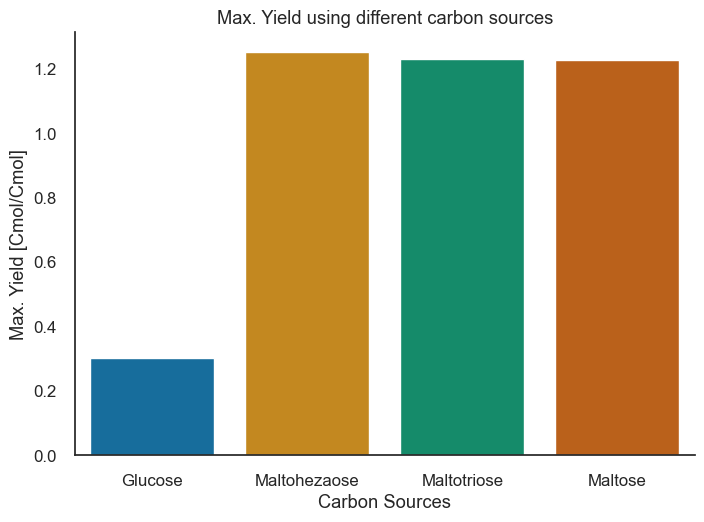

In [72]:
# Generate bar plot to visualize cmol/cmol

# Write values
yield_glucose_cmol = Asp_glucose_production_cmol
yield_maltohezaose_cmol = asp_malthx_production_cmol
yield_maltotriose_cmol = asp_maltotriose_production_cmol
yield_maltose_cmol = asp_maltose_production_cmol

# Carbon sources
carbon_sources_cmol = ['Glucose', 'Maltohezaose', 'Maltotriose', 'Maltose']

# Maximum yields
max_yields_cmol = [yield_glucose_cmol, yield_maltohezaose_cmol, yield_maltotriose_cmol, yield_maltose_cmol]

# Plotting
sns.barplot(x=carbon_sources_cmol, y=max_yields_cmol, palette='colorblind')
plt.xlabel('Carbon Sources')
plt.ylabel('Max. Yield [Cmol/Cmol]')
plt.title('Max. Yield using different carbon sources')
sns.despine()
plt.show()